In [1]:
import tensorflow as tf

import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image


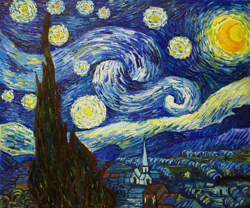

In [2]:
image_path = r"starry_night.jpg"

def open_img(image_path, resize=0):
    img = PIL.Image.open(image_path)
    if resize:
        h, w = img.size
        new_h = h//4
        new_w = w//4
        img = img.resize((new_h, new_w))
    return np.array(img)

# Normalize an image
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

# Display an image
def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))


img = open_img(image_path,1)

show(img)

In [3]:
base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
include_top=False, weights='imagenet')


219055592/219055592 [==============================] - 83s 0us/step


In [4]:
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                             

In [5]:
# Maximize the activations of these layers
names = ['block35_1_mixed', 'mixed_5b','block35_3_mixed']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)


In [6]:
def calc_loss(img, model):
    # Pass forward the image through the model to retrieve the activations.
    # Converts the image into a batch of size 1.
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return  tf.reduce_sum(losses)


In [7]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
    )
    def __call__(self, img, steps, step_size):
        print("Tracing")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                # This needs gradients relative to `img`
                # `GradientTape` only watches `tf.Variable`s by default
                tape.watch(img)
                loss = calc_loss(img, self.model)

            # Calculate the gradient of the loss with respect to the pixels of the input image.
            gradients = tape.gradient(loss, img)

            # Normalize the gradients.
            gradients /= tf.math.reduce_std(gradients) + 1e-8 

            # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
            # You can update the image by directly adding the gradients (because they're the same shape!)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)

        return loss, img

In [8]:
deepdream = DeepDream(dream_model)


In [9]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
    # Convert from uint8 to the range expected by the model.
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    while steps_remaining:
        if steps_remaining>100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -= run_steps
        step += run_steps

        loss, img = deepdream(img, run_steps, tf.constant(step_size))

        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Step {}, loss {}".format(step, loss))


    result = deprocess(img)
    display.clear_output(wait=True)
    show(result)

    return result


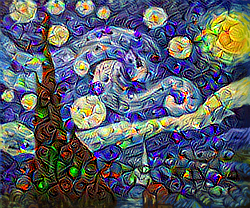

In [10]:
dream_img = run_deep_dream_simple(img=img, 
                                  steps=50, step_size=0.02)


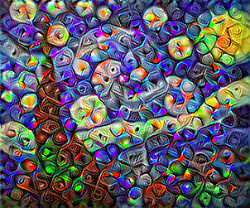

16.104440689086914

In [11]:
import time
start = time.time()

OCTAVE_SCALE = 1.10

img1 = tf.constant(np.array(img))
base_shape = tf.shape(img1)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
    new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

    img1 = tf.image.resize(img1, new_shape).numpy()

    img1 = run_deep_dream_simple(img=img1, steps=50, step_size=0.01)

display.clear_output(wait=True)
img1 = tf.image.resize(img1, base_shape)
img1 = tf.image.convert_image_dtype(img1/255.0, dtype=tf.uint8)
show(img1)

end = time.time()
end-start

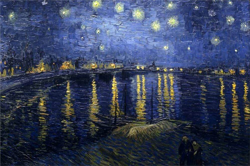

In [12]:
image_path = "the-starry-night-over-the-rhone.jpg"
img = open_img(image_path,1)
show(img)

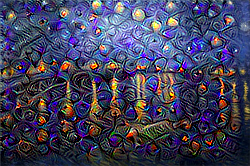

In [13]:
dream_img = run_deep_dream_simple(img=img, 
                                  steps=50, step_size=0.02)

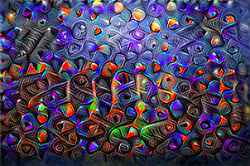

12.751169681549072

In [14]:
import time
start = time.time()

OCTAVE_SCALE = 1.10

img1 = tf.constant(np.array(img))
base_shape = tf.shape(img1)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
    new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

    img1 = tf.image.resize(img1, new_shape).numpy()

    img1 = run_deep_dream_simple(img=img1, steps=50, step_size=0.01)

display.clear_output(wait=True)
img1 = tf.image.resize(img1, base_shape)
img1 = tf.image.convert_image_dtype(img1/255.0, dtype=tf.uint8)
show(img1)

end = time.time()
end-start

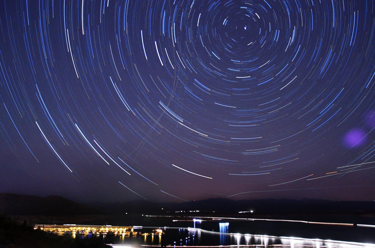

In [15]:
image_path = "Stargazing-near-Phoenix-Lake-Pleasant-Ryan-Cadby-via-Flickr.jpg"
img = open_img(image_path,1)
show(img)

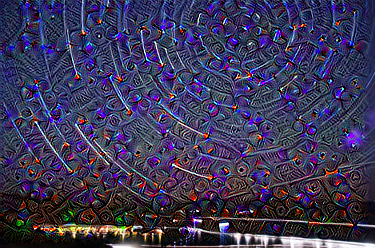

In [16]:
dream_img = run_deep_dream_simple(img=img, 
                                  steps=50, step_size=0.02)

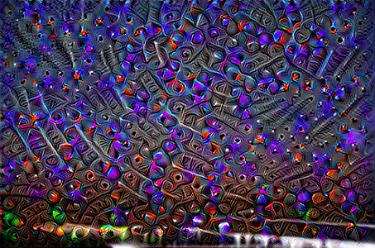

28.418663501739502

In [17]:
import time
start = time.time()

OCTAVE_SCALE = 1.1

img1 = tf.constant(np.array(img))
base_shape = tf.shape(img1)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
    new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

    img1 = tf.image.resize(img1, new_shape).numpy()

    img1 = run_deep_dream_simple(img=img1, steps=50, step_size=0.01)

display.clear_output(wait=True)
img1 = tf.image.resize(img1, base_shape)
img1 = tf.image.convert_image_dtype(img1/255.0, dtype=tf.uint8)
show(img1)

end = time.time()
end-start

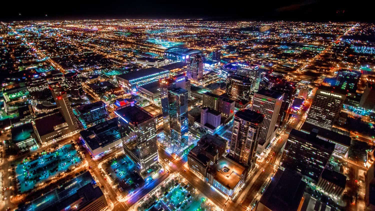

In [18]:
image_path = "Stargazing-in-Phoenix-Jerry-Ferguson-via-Flickr.jpg"
img = open_img(image_path,1)
show(img)

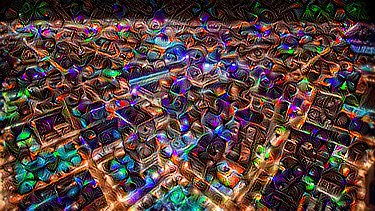

In [19]:
dream_img = run_deep_dream_simple(img=img, 
                                  steps=50, step_size=0.02)

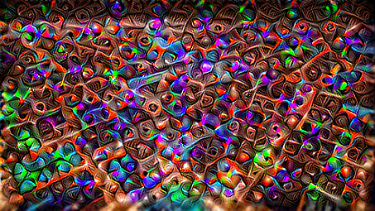

23.94005060195923

In [20]:
import time
start = time.time()

OCTAVE_SCALE = 1.1

img1 = tf.constant(np.array(img))
base_shape = tf.shape(img1)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
    new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

    img1 = tf.image.resize(img1, new_shape).numpy()

    img1 = run_deep_dream_simple(img=img1, steps=50, step_size=0.01)

display.clear_output(wait=True)
img1 = tf.image.resize(img1, base_shape)
img1 = tf.image.convert_image_dtype(img1/255.0, dtype=tf.uint8)
show(img1)

end = time.time()
end-start